### Import libraries

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import plotly.express as px
import plotly.graph_objects as go
import os
from windrose import WindroseAxes

### Load dataset

In [16]:
df = pd.read_csv('C:/Users/Hp victus/Documents/!0 Acedamy/solar-challenge-week1/data/benin-malanville.csv', parse_dates=['Timestamp'])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Timestamp      525600 non-null  datetime64[ns]
 1   GHI            525600 non-null  float64       
 2   DNI            525600 non-null  float64       
 3   DHI            525600 non-null  float64       
 4   ModA           525600 non-null  float64       
 5   ModB           525600 non-null  float64       
 6   Tamb           525600 non-null  float64       
 7   RH             525600 non-null  float64       
 8   WS             525600 non-null  float64       
 9   WSgust         525600 non-null  float64       
 10  WSstdev        525600 non-null  float64       
 11  WD             525600 non-null  float64       
 12  WDstdev        525600 non-null  float64       
 13  BP             525600 non-null  int64         
 14  Cleaning       525600 non-null  int64         
 15  

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04:00,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05:00,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN


Drop the completely empty 'Comments' column because it is when it compared to the whole dataset

In [17]:
 df.drop(columns=['Comments'], inplace=True)

Basic statistics and missing values

In [37]:
df.describe()
df.isna().sum()

Timestamp        0
GHI              0
DNI              0
DHI              0
ModA             0
ModB             0
Tamb             0
RH               0
WS               0
WSgust           0
WSstdev          0
WD               0
WDstdev          0
BP               0
Cleaning         0
Precipitation    0
TModA            0
TModB            0
OutlierFlag      0
dtype: int64

### Identify outliers using Z-score

In [39]:
z_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_scores = df[z_cols].apply(zscore)
df['OutlierFlag'] = (np.abs(z_scores) > 3).any(axis=1)
print(f"Outliers found: {df['OutlierFlag'].sum()}")

Outliers found: 7740


Drop all rows flagged as outliers

In [40]:
df_clean = df[~df['OutlierFlag']].copy()
df_clean.drop(columns=['OutlierFlag'], inplace=True)

Save Clean Dataset

In [41]:
os.makedirs('data', exist_ok=True)
df_clean.to_csv('data/benin_clean.csv', index=False)

### Show cleaning impact Average ModA & ModB pre/post clean

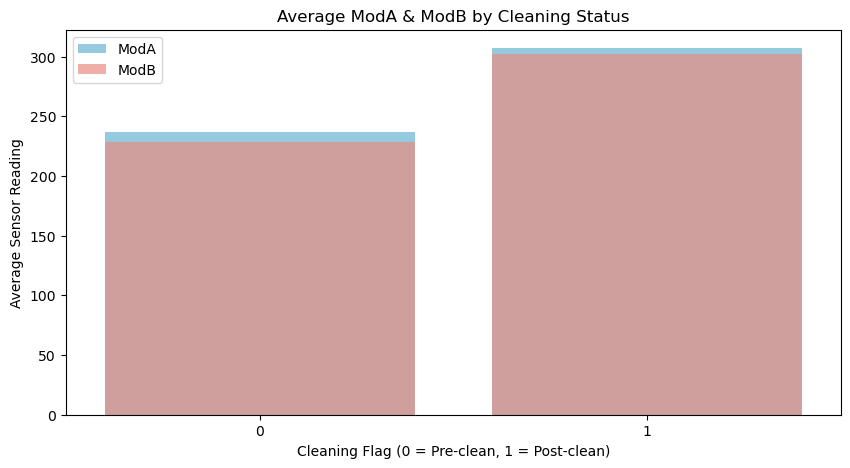

In [43]:
plt.figure(figsize=(10,5))
cleaning_group = df.groupby('Cleaning')[['ModA', 'ModB']].mean().reset_index()
sns.barplot(x='Cleaning', y='ModA', data=cleaning_group, color='skyblue', label='ModA')
sns.barplot(x='Cleaning', y='ModB', data=cleaning_group, color='salmon', label='ModB', alpha=0.7)
plt.title('Average ModA & ModB by Cleaning Status')
plt.xlabel('Cleaning Flag (0 = Pre-clean, 1 = Post-clean)')
plt.ylabel('Average Sensor Reading')
plt.legend()
plt.show()

### Time Series Analysis — plot GHI, DNI, DHI, Tamb over time

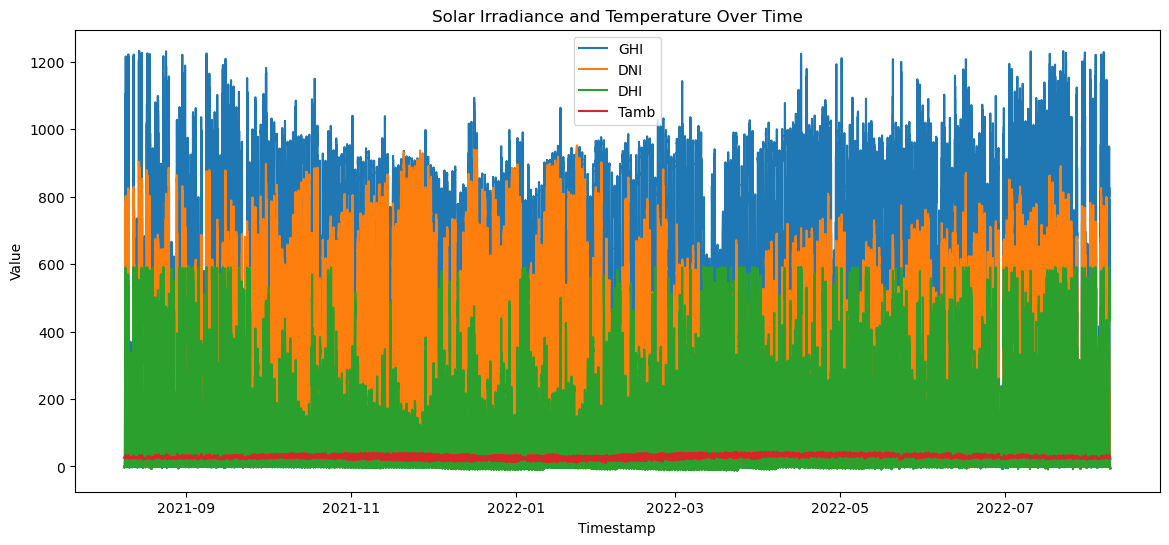

In [44]:
plt.figure(figsize=(14, 6))
plt.plot(df_clean['Timestamp'], df_clean['GHI'], label='GHI')
plt.plot(df_clean['Timestamp'], df_clean['DNI'], label='DNI')
plt.plot(df_clean['Timestamp'], df_clean['DHI'], label='DHI')
plt.plot(df_clean['Timestamp'], df_clean['Tamb'], label='Tamb')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Solar Irradiance and Temperature Over Time')
plt.legend()
plt.show()

### Correlation heatmap for key numeric columns
Features with weak or no correlation to the target may be dropped in modeling stages.

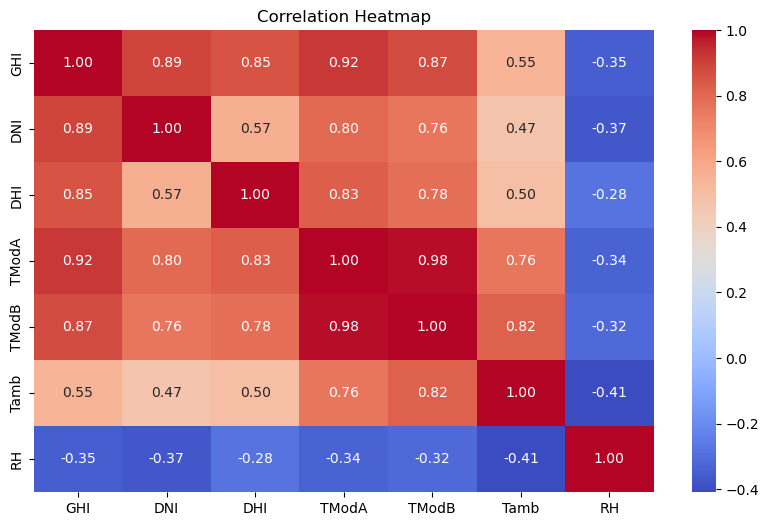

In [45]:
plt.figure(figsize=(10, 6))
corr = df_clean[['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'Tamb', 'RH']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

### Scatter Plots WS, WSgust, WD vs GHI

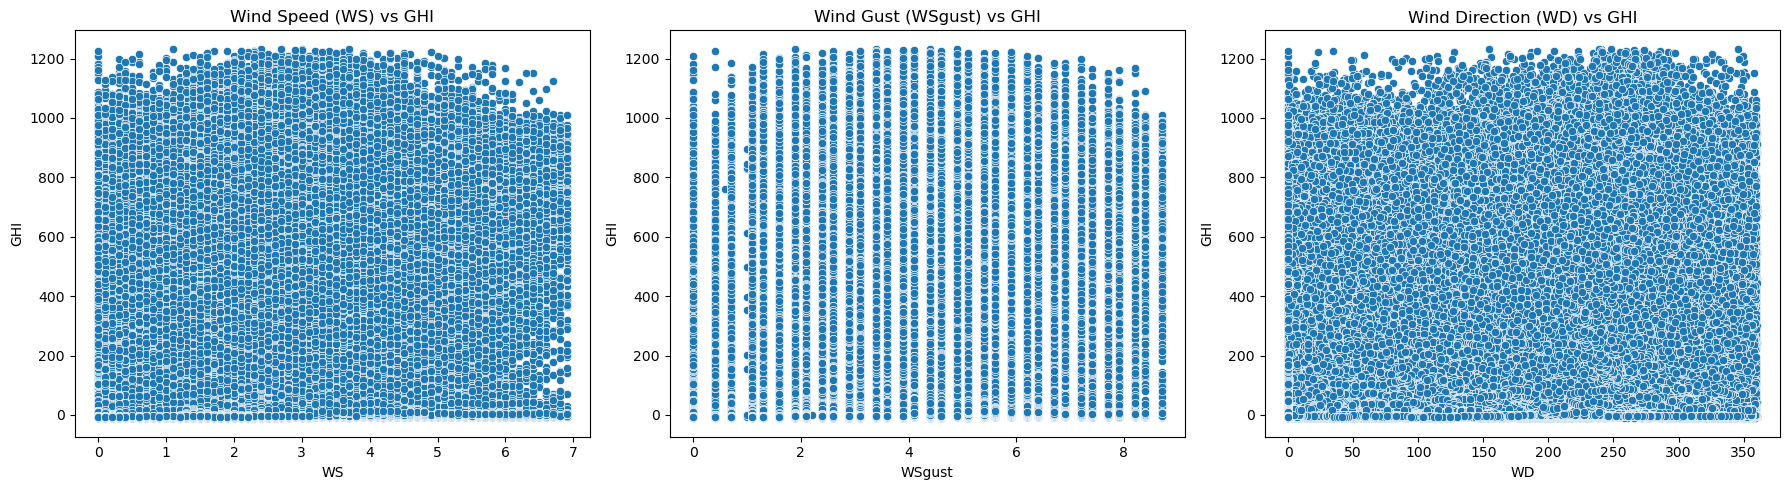

In [54]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(data=df_clean, x='WS', y='GHI', ax=axs[0])
axs[0].set_title('Wind Speed (WS) vs GHI')

sns.scatterplot(data=df_clean, x='WSgust', y='GHI', ax=axs[1])
axs[1].set_title('Wind Gust (WSgust) vs GHI')

sns.scatterplot(data=df_clean, x='WD', y='GHI', ax=axs[2])
axs[2].set_title('Wind Direction (WD) vs GHI')

plt.tight_layout()
plt.show()

### Scatter Plots RH vs Tamb and RH vs GHI

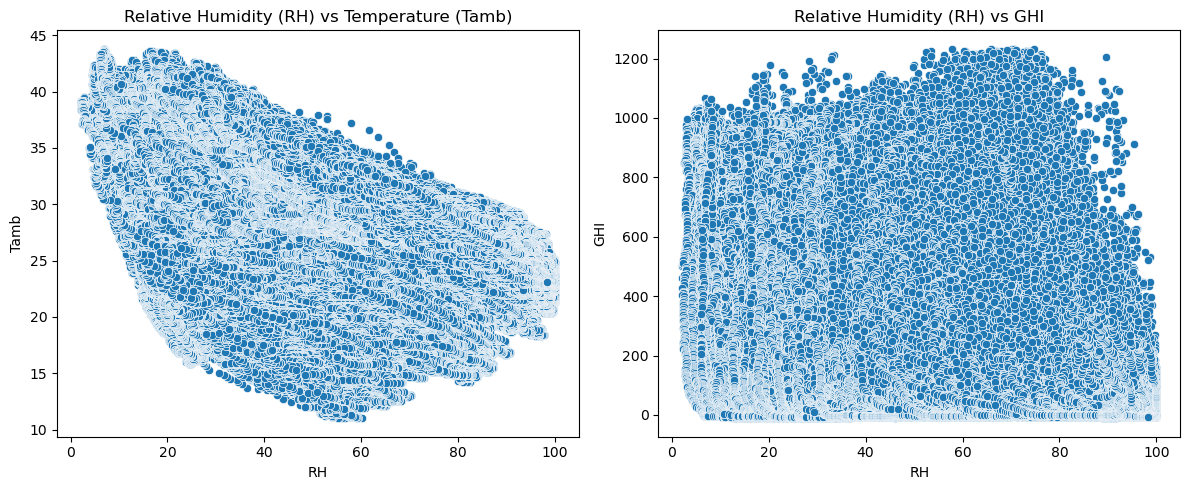

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(data=df_clean, x='RH', y='Tamb', ax=axs[0])
axs[0].set_title('Relative Humidity (RH) vs Temperature (Tamb)')

sns.scatterplot(data=df_clean, x='RH', y='GHI', ax=axs[1])
axs[1].set_title('Relative Humidity (RH) vs GHI')

plt.tight_layout()
plt.show()

### Wind rose plot for WS and WD

<Figure size 800x800 with 0 Axes>

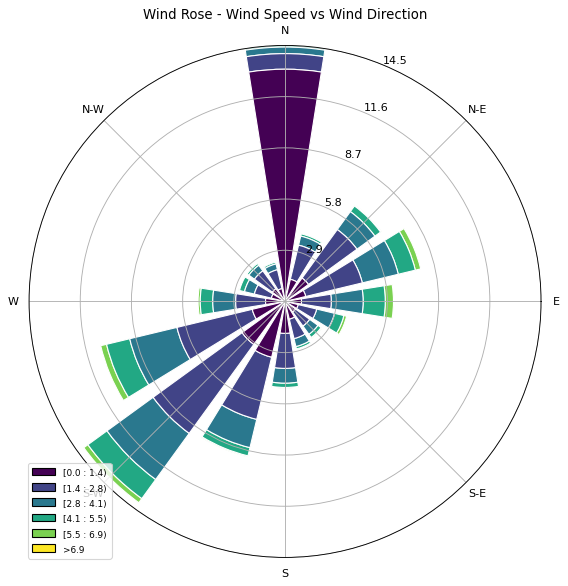

In [55]:
plt.figure(figsize=(8,8))
ax = WindroseAxes.from_ax()
ax.bar(df_clean['WD'], df_clean['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_title('Wind Rose - Wind Speed vs Wind Direction')
ax.set_legend()
plt.show()

### Histograms for GHI and WS

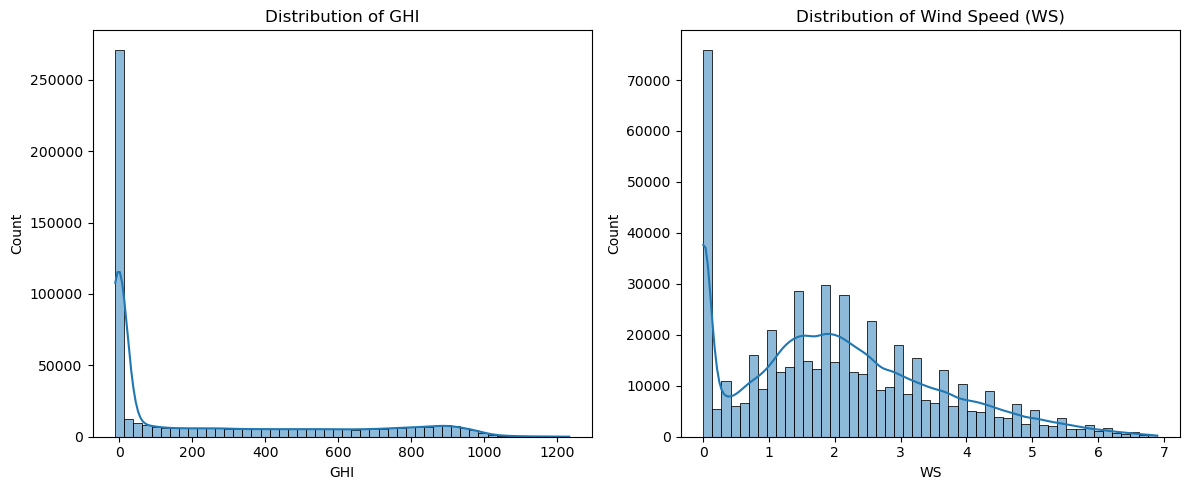

In [50]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_clean['GHI'], bins=50, kde=True)
plt.title('Distribution of GHI')

plt.subplot(1, 2, 2)
sns.histplot(df_clean['WS'], bins=50, kde=True)
plt.title('Distribution of Wind Speed (WS)')

plt.tight_layout()
plt.show()

### Bubble chart: GHI vs Tamb with bubble size by RH and color by BP

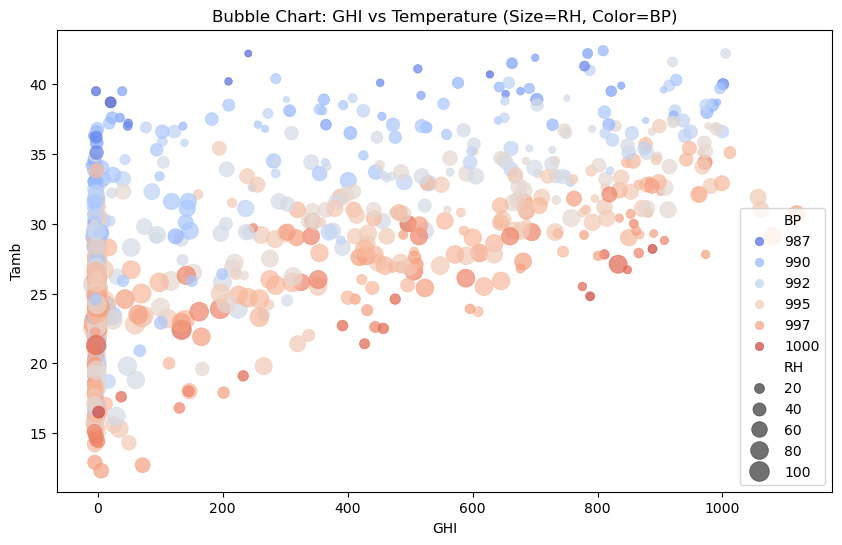

In [52]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_clean.sample(1000),  # sample if dataset is large
    x='GHI',
    y='Tamb',
    size='RH',
    hue='BP',
    palette='coolwarm',
    sizes=(20, 200),
    alpha=0.7,
    edgecolor=None
)
plt.title('Bubble Chart: GHI vs Temperature (Size=RH, Color=BP)')
plt.show()